In [27]:
%%shell
wget 'https://raw.githubusercontent.com/mazyvan/most-common-spanish-words/master/most-common-spanish-words-v5.txt' -O spanish.txt
wget 'https://raw.githubusercontent.com/webpwnized/byepass/master/dictionaries/top-10000-english-words.txt' -O english.txt

--2023-10-07 01:04:53--  https://raw.githubusercontent.com/mazyvan/most-common-spanish-words/master/most-common-spanish-words-v5.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95006 (93K) [text/plain]
Saving to: ‘spanish.txt’

spanish.txt         100%[===================>]  92.78K  --.-KB/s    in 0.08s   

2023-10-07 01:04:54 (1.16 MB/s) - ‘spanish.txt’ saved [95006/95006]

--2023-10-07 01:04:54--  https://raw.githubusercontent.com/webpwnized/byepass/master/dictionaries/top-10000-english-words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

In [28]:
%%shell
pip install unidecode

In [114]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import ArrayLike
from unidecode import unidecode
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


# Carga de Datos

In [30]:
x = map(lambda i: i ** 2, range(10))
x

In [31]:
list(x)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [32]:
*y, = x
y

[]

In [39]:
with open("spanish.txt", "r") as f:
    *spa, = filter(
        lambda word: len(word) > 0,
        f.read().split("\n")
    )

with open("english.txt", "r") as f:
    *en, = filter(
        lambda word: len(word) > 0,
        f.read().split("\n")
    )

In [40]:
en[:20]

['a',
 'aa',
 'aaa',
 'aaron',
 'abandoned',
 'abc',
 'aberdeen',
 'abilities',
 'ability',
 'aboriginal',
 'abortion',
 'about',
 'above',
 'abraham',
 'abroad',
 'abs',
 'absence',
 'absent',
 'absolute',
 'absolutely']

In [41]:
len(spa)

10911

In [42]:
len(en)

8830

In [43]:
df_es = pd.DataFrame(data=dict(word=spa, label="spanish"))
df_en = pd.DataFrame(data=dict(word=en, label="english"))
df = (
    pd.concat([df_es, df_en])
    .assign(word=lambda df: df.word.apply(unidecode))
)

In [44]:
df

,word,label
0,de,spanish
1,que,spanish
2,no,spanish
3,a,spanish
4,la,spanish
...,...,...
8825,zoophilia,english
8826,zope,english
8827,zshops,english
8828,zum,english


# Extraccion de Caracteristicas

In [101]:
pipe = spacy.load("en_core_web_md")

In [92]:
#vect = CountVectorizer(ngram_range=(2, 5), analyzer="char", min_df=10).fit(df.word)
#vect = TfidfVectorizer( ngram_range=(2, 4), analyzer="char", min_df=10, sublinear_tf=True ).fit(df.word)
#features = vect.transform(df.word)
labeler = LabelEncoder().fit(df.label)

In [104]:
def feature_extractor(word: str) -> ArrayLike:
    doc = pipe(word)
    return doc.vector.reshape(1, -1)

In [105]:
vects = []
for word in tqdm(df.word.to_list()):
    vects.append(feature_extractor(word))

100%|██████████| 19741/19741 [02:49<00:00, 116.24it/s]


In [107]:
features = np.concatenate(vects, axis=0)

In [108]:
labels = labeler.transform(df.label)

In [109]:
features.shape

(19741, 300)

In [110]:
labels.shape

(19741,)

In [111]:
(
    features_train,
    features_test,
    labels_train,
    labels_test
) = train_test_split(
    features, labels, test_size=0.3, random_state=0,
    stratify=labels
    )

# Model

In [112]:
model = LogisticRegression().fit(features_train, labels_train)
#model = SVC().fit(features_train, labels_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Evaluation

In [113]:
model.score(features_test, labels_test)

0.8630761438460239

In [115]:
labeler.classes_

array(['english', 'spanish'], dtype=object)

In [116]:
y_pred = model.predict(features_test)
cm = confusion_matrix(labels_test, y_pred)
scratch_df = pd.DataFrame(cm, columns=labeler.classes_, index=labeler.classes_)

[Text(0.5, 23.52222222222222, 'Predicho'),
 Text(50.722222222222214, 0.5, 'Real')]

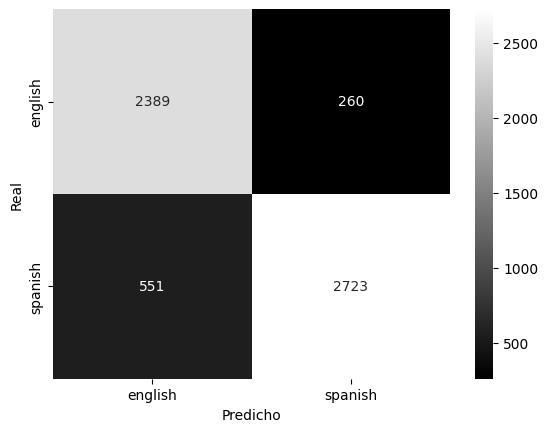

In [121]:
fig, ax = plt.subplots()
sns.heatmap(scratch_df, ax=ax, cmap="gray", annot=True, fmt=".0f")
ax.set(xlabel="Predicho", ylabel="Real")

In [166]:
word = "word"

In [167]:
vect = pipe(word).vector.reshape(1, -1)

In [168]:
y_pred = model.predict(vect)

In [169]:
labeler.inverse_transform(y_pred)

array(['english'], dtype=object)